In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

# Non linear system example

Suppose you're given a two dimensional non-linear system to solve (See Charnley Example 5.3.2).

$$ \frac{dx}{dt} = ax(K-x)-bxy $$

$$ \frac{dy}{dt} = cy(M-y)-dxy $$

a. Does this system of differential equations better fit with a competing species model or a predator-prey model? If it is predator-prey, which species is the predator?

b. Find and classify the critical point (if it exists) with both x > 0 and y > 0.

c. Describe what is going to happen to the population of these species over time. If this depends on the initial condition, say so.

d. Evaluate the time evolution of the system numerically from one or more initial conditions. Make a graph of this result.

e. Create a phase portrait of the system showing the critical/fixed points as well as the trajectory you evaluated in (d) above.

f. Create a linearized model of the system that's valid in the vicinity of one of the critial points

g. Graph the linearized model overlaid on the graph from (d).



In [2]:
#
# example non-linear system exploration, sympy and numpy
#

t = sp.symbols("t", real=True, positive=True)
x,y = sp.symbols("x,y", real=True) # not positive, since we need to find solutions where x=0, y=0
dx,dy = sp.symbols('delta_x, delta_y', real=True)

In [3]:
f = 4*x - x**2 - 2*x*y # create sympy functions for f(x,y), g(x,y).
g = 7*y - y**2 - 3*x*y
p = sp.Matrix([f,g])
jac = p.jacobian([x,y]) # evaluate jacobian
jac

Matrix([
[-2*x - 2*y + 4,           -2*x],
[          -3*y, -3*x - 2*y + 7]])

In [4]:
solns = sp.solve((f,g),(x,y)) # find fixed points
solns # note we now see solutions where x=0, y=0

[(0, 0), (0, 7), (2, 1), (4, 0)]

In [5]:
x0,y0 = solns[2] # pick out 'coexistance' solution
x0,y0

(2, 1)

In [6]:
fn=sp.lambdify((x,y),f,'numpy') # get numpy version of the functions for numerical
gn=sp.lambdify((x,y),g,'numpy') # calculation (e.g., RK4, Heun, Euler, etc.)

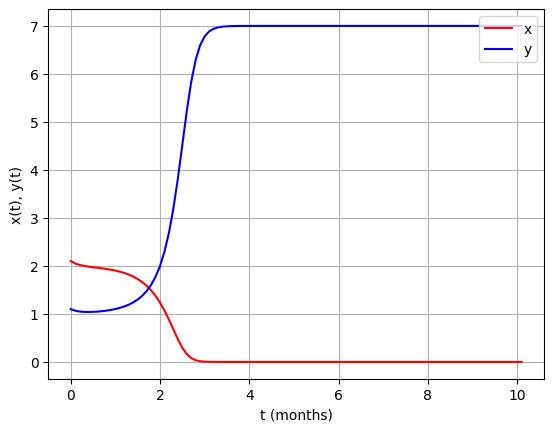

In [7]:
def RK4Step(s, f, t, dt):
    f1 = f(s,t)
    f2 = f(s+f1*dt/2, t+dt/2)
    f3 = f(s+f2*dt/2, t+dt/2)
    f4 = f(s+f3*dt, t+dt)
    return s + (f1 + 2*f2 + 2*f3 + f4)*dt/6

def f_interaction(s, t):
    "numpy function to compute vector derivative"
    x = s[0]
    y = s[1]
    return np.array([fn(x,y), gn(x,y)])

x0n=float(x0)+0.1 # start a bit away from (x0,y0)
y0n=float(y0)+0.1

s = np.array([x0n, y0n]) # intialize the state with c0, f0

tn = 0
tmax = 10
dt = 0.1
xList = [s[0]]
yList = [s[1]]
tList = [tn]

while tn < tmax:
    s = RK4Step(s, f_interaction, tn, dt)
    tn = tn + dt
    xList.append(s[0])
    yList.append(s[1])
    tList.append(tn)

plt.plot(tList, xList, 'r-', label='x')
plt.plot(tList, yList, 'b-', label='y')
plt.grid()
plt.xlabel("t (months)")
plt.ylabel("x(t), y(t)")
plt.legend(loc="upper right")

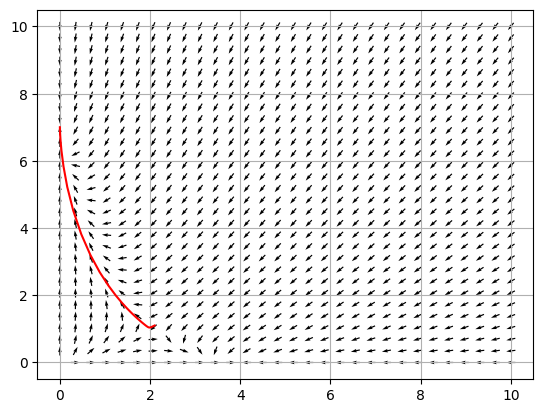

In [8]:
#
# Note this is not showing slopes over time, but directions in the c-f plane
#

xdomain = np.linspace(0,10,30) # x, need to keep the aspect ratio=1
ydomain = np.linspace(0,10,30) # y

xm,ym = np.meshgrid(xdomain, ydomain) # xmesh and ymash

sm = np.array([xm,ym]) # smesh as welll

u,v = f_interaction(sm, 0) # get dc/dt and df/dt for all the values of c and f.
uvmag = np.sqrt(u**2+v**2) # magnitude of u,v field for scaling
uvmag = np.where(uvmag<1e-10,1,uvmag) # just avoid dividing by zero

plt.quiver(xm,ym,u/uvmag,v/uvmag,pivot='mid')
plt.plot(xList,yList,'r-')
plt.grid()


In [9]:
A = jac.subs({x:x0, y:y0}) # evaluate jac at fixed point
A

Matrix([
[-2, -4],
[-3, -1]])

In [10]:
P,D = A.diagonalize()
P,D

(Matrix([
 [4, -1],
 [3,  1]]),
 Matrix([
 [-5, 0],
 [ 0, 2]]))

In [11]:
dy0 = sp.Matrix([1,1])/10
dy0

Matrix([
[1/10],
[1/10]])

In [12]:
dy = P*sp.exp(D*t)*P.inv()*dy0
re_part,im_part=dy.as_real_imag()
re_part

Matrix([
[-exp(2*t)/70 + 4*exp(-5*t)/35],
[ exp(2*t)/70 + 3*exp(-5*t)/35]])

In [13]:
dx_linear = sp.lambdify(t,re_part[0],'numpy')
dy_linear = sp.lambdify(t,re_part[1],'numpy')

(0.0, 10.0)

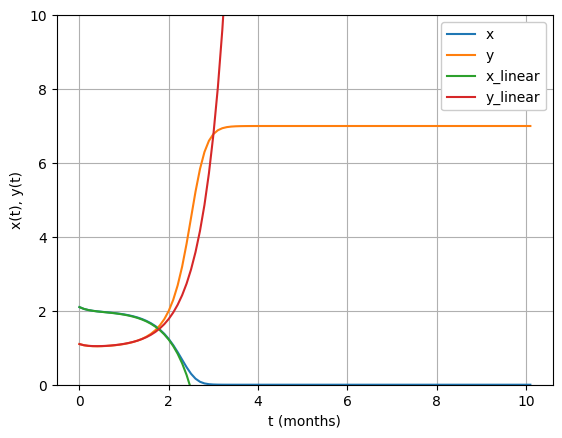

In [14]:
tListN=np.array(tList)
plt.plot(tList, xList, label='x')
plt.plot(tList, yList, label='y')
plt.plot(tList, dx_linear(tListN)+float(x0), label='x_linear')
plt.plot(tList, dy_linear(tListN)+float(y0), label='y_linear')
plt.grid()
plt.xlabel("t (months)")
plt.ylabel("x(t), y(t)")
plt.legend(loc="upper right", framealpha=1)
plt.ylim([0,10])


(0.0, 10.0)

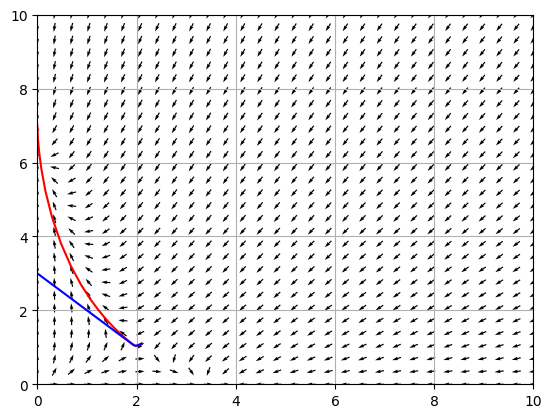

In [15]:
plt.quiver(xm,ym,u/uvmag,v/uvmag,pivot='mid')
plt.plot(xList,yList,'r-')
plt.plot(dx_linear(tListN)+float(x0), dy_linear(tListN)+float(y0), 'b-')
plt.grid()
plt.ylim([0,10])
plt.xlim([0,10])